# Create a phase curve

``squishyplanet`` can also model phase curves of triaxial planets, though admittedly, its approach is much cruder here than when modeling transit-only lightcurves. We still use the same 3D description of the planet, but then the analytics fall away and we just Monte Carlo sample the visible disk of the planet as seen from the observer at each timestep. This is both slow and memory intensive, but does in theory provide for some flexibility to choose interesting reflection/emission laws. Pre-version 1.0, ``squishyplanet`` only supports uniform albedo Lambertian scattering for reflections and a single hotspot modeled by a von Mises-Fisher distribution for thermal emission, though hopefully more options will be added in the future.

``squishyplanet`` handles secondary eclipses just by masking each sample of the surface according to whether it's behind the star or not.

Finally, ``squishyplanet`` also can "model" stellar ellipsoidal variations caused by gravity-induced darkening and stellar doppler beaming effects. However, these are not super physically motivated and are just sinusoids with periods of twice and equal to the orbital period, respectively. These are scaled by a user-provided amplitude (or fitted) amplitude: these amplitudes are related to other parameters in the model (e.g. [Wong et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract>)), but it's up to the user to include those relationships in a prior if they wish.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

from squishyplanet import OblateSystem

## Reflections

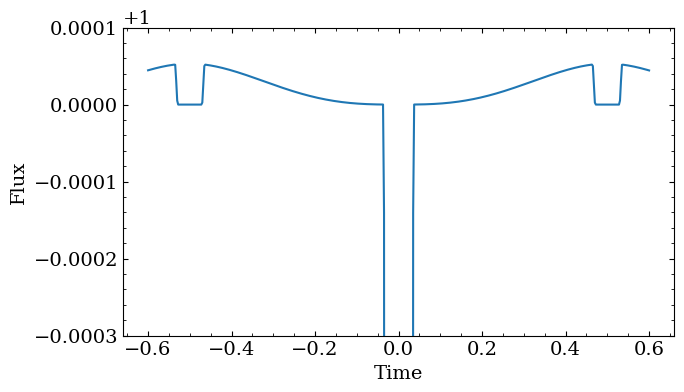

In [4]:
state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.6, 0.6, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2, 
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "tidally_locked" : False,
    "compute_reflected_phase_curve" : True,
    "albedo" : 0.2,
}
planet = OblateSystem(**state)

fig, ax = plt.subplots()
ax.plot(planet.state["times"], planet.lightcurve())
w = 3e-4
ax.set(ylim=[1-3e-4, 1+1e-4], xlabel="Time", ylabel="Flux");

To estimate the noise/bias introduced by our Monte Carlo estimate, we can set an identical system with a different random seed and compare the two estimates:

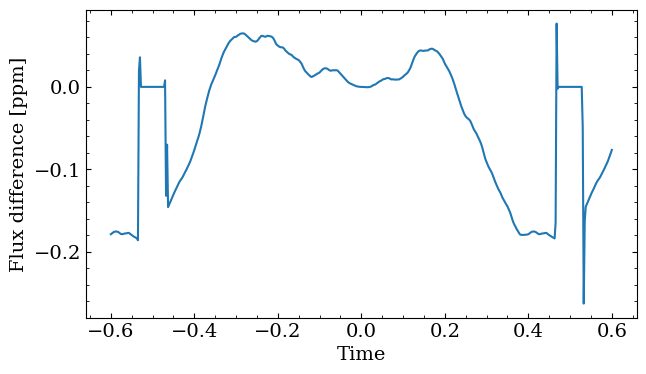

In [5]:
state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.6, 0.6, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2, 
    "ld_u_coeffs":jnp.array([0.4, 0.26]),
    "tidally_locked" : False,
    "compute_reflected_phase_curve" : True,
    "albedo" : 0.2,
    "random_seed" : 0,
}
planet1 = OblateSystem(**state)

state["random_seed"] = 1
planet2 = OblateSystem(**state)

diff = planet1.lightcurve() - planet2.lightcurve()

fig, ax = plt.subplots()
ax.plot(planet1.state["times"], diff*1e6)
ax.set(xlabel="Time", ylabel="Flux difference [ppm]");


Here it looks like the noise is likely acceptable with the default settings, which use 50,000 samples per timestep.

Lastly, we can compare our reflect curves of spherical planets with ``starry``'s estimate of the same system. Since as of writing ``starry`` is difficult to install due to some dependency conflicts, we pre-generated this curve using ``starry`` v1.2.0:

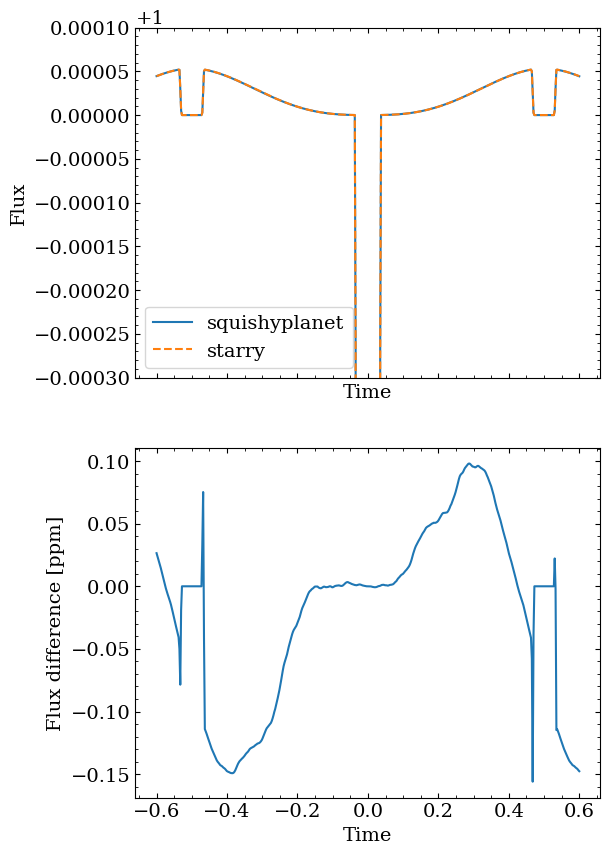

In [13]:
# import astropy.units as u
# import astropy.constants as const
# import numpy as np
# import matplotlib.pyplot as plt
# import starry
# starry.config.lazy = False
# starry.config.quiet = True
# star_mass = ((5.0*u.R_sun)**3 / (1.0*u.day)**2 / (const.G) * (4*np.pi**2)).to(u.M_sun).value
# starry.config.lazy = False
# starry.config.quiet = True
# sun = starry.Primary(starry.Map(), r=1, length_unit=u.Rsun, m=star_mass, m_unit=u.Msun)
# map = starry.Map(reflected=True)
# planet = starry.Secondary(map, a=5.0, m=0.0, inc=90, r=0.1, length_unit=u.Rsun)
# planet.map.amp = 0.2
# sys = starry.System(sun, planet)
# np.save("starry_reflected_curve.npy", sys.flux(t))

starry_flux = np.load("starry_reflected_curve.npy")


state = {
    "t_peri" : -0.25,
    "times" : jnp.linspace(-0.6, 0.6, 500),
    "a" : 5.0,
    "period" : 1.0,
    "r" : 0.1,
    "i" : jnp.pi/2, 
    "ld_u_coeffs":jnp.array([0.0, 0.0]),
    "tidally_locked" : False,
    "compute_reflected_phase_curve" : True,
    "albedo" : 0.2,
}
planet = OblateSystem(**state)
lc = planet.lightcurve()

fig, axs = plt.subplots(nrows=2, figsize=(6,10), sharex=True)
axs[0].plot(planet.state["times"], lc, label="squishyplanet")
axs[0].plot(planet.state["times"], starry_flux, ls="--", label="starry")
w = 3e-4
axs[0].set(ylim=[1-3e-4, 1+1e-4], xlabel="Time", ylabel="Flux");
axs[0].legend()

axs[1].plot(planet.state["times"], 1e6*(lc - starry_flux))
axs[1].set(xlabel="Time", ylabel="Flux difference [ppm]");

## Emission only

In [ ]:
# move the hotspot around, difference between substellar and slightly shifted

## Stellar effects

In [ ]:
# beaming, ellipsoidal variations

## Extended emission

In progress!